In [47]:
from typing import List, Tuple

import matplotlib.pyplot as plt

from elections.DefaultConfigOptions import unit_election_config
from Experiment import Experiment
from ExperimentalConfig import ExperimentalConfig
from elections.ElectionConstructor import ElectionConstructor, construct_irv, construct_h2h
from elections.Candidate import Candidate
from elections.Ballot import Ballot

n_races=1000

h2h_config = ExperimentalConfig("H2H",
                            10000,
                            1.5, .7, 21, 512, 3, 20000, 2048, 400, 1000, "exp/h2h-0")
h2h_config.save()
h2h_exp = Experiment(h2h_config)

In [48]:
irv_config = ExperimentalConfig("IRV",
                            10000,
                            1.5, .7, 21, 512, 3, 20000, 2048, 400, 1000, "exp/irv-0")
irv_config.save()
irv_exp = Experiment(irv_config)

In [49]:
irv_wc_s = irv_exp.run_strategic_races_core(n_races)
h2h_wc_s = h2h_exp.run_strategic_races_core(n_races)

    0 w.ideology: 0.6316
  100 w.ideology: -0.4473
  200 w.ideology: -0.5047
  300 w.ideology: -0.2723
  400 w.ideology: -0.4854
  500 w.ideology: -0.3901
  600 w.ideology: 0.4794
  700 w.ideology: 0.3474
  800 w.ideology: 0.4302
  900 w.ideology: 0.5604
    0 w.ideology: 0.1287
  100 w.ideology: -0.1049
  200 w.ideology: -0.02389
  300 w.ideology: 0.01558
  400 w.ideology: -0.07031
  500 w.ideology: 0.2294
  600 w.ideology: 0.00478
  700 w.ideology: -0.04828
  800 w.ideology: 0.05425
  900 w.ideology: 0.04124


In [50]:
import numpy as np
def plot_results(results: List[List[float]], title: str, labels: List[str]):
    n_rows = 1
    n_cols = 1
    fig, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))
    fig.suptitle(title, color="black", fontsize=22)
    fig.set_facecolor("white")

    count = 0
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    axis.tick_params(axis='x', colors="black")
    axis.tick_params(axis='y', colors="black")
    axis.set_xlim([-1, 1])

    bins = np.arange(-1, 1, 2/21)
    axis.hist(results, bins=bins, label=labels, edgecolor='white', stacked=True)
    axis.legend()
    axis.set_xlabel("Sigma From Origin", fontsize=20)
    axis.set_ylabel("Frequency of Winner at Ideology", fontsize=20)

    plt.savefig("foo.png")

In [51]:
def results_for_candidate(results: List[Tuple[Candidate, List[Candidate]]], candidate_name: str, wins_only: bool):
    ideologies = []
    for w, cc in results:
        if wins_only and w.name == candidate_name:
            ideologies.append(w.ideology.vec[0])
        elif not wins_only:
            for c in cc:
                if c.name == candidate_name:
                    ideologies.append( c.ideology.vec[0] )

    print(f"found {len(ideologies)} results")
    return ideologies

found 225 results
found 207 results
found 184 results
found 199 results
found 185 results
found 199 results
found 199 results
found 170 results
found 220 results
found 212 results
found 1000 results
found 1000 results
found 1000 results
found 1000 results
found 1000 results
found 1000 results
found 1000 results
found 1000 results
found 1000 results
found 1000 results


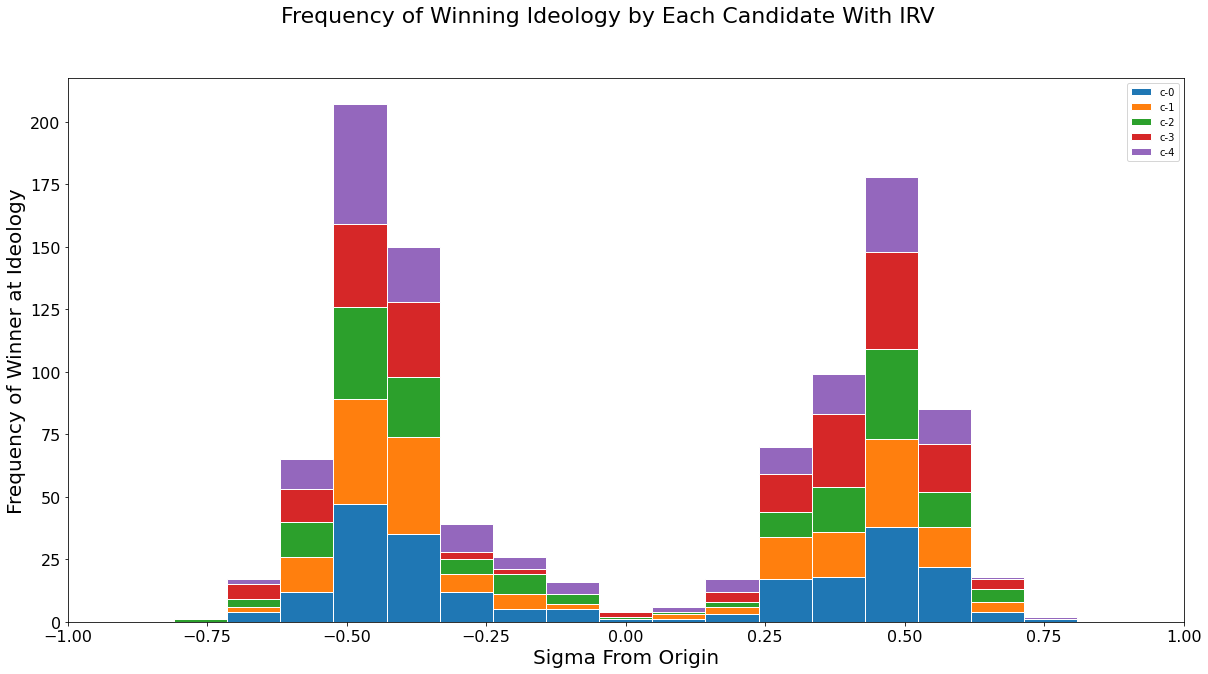

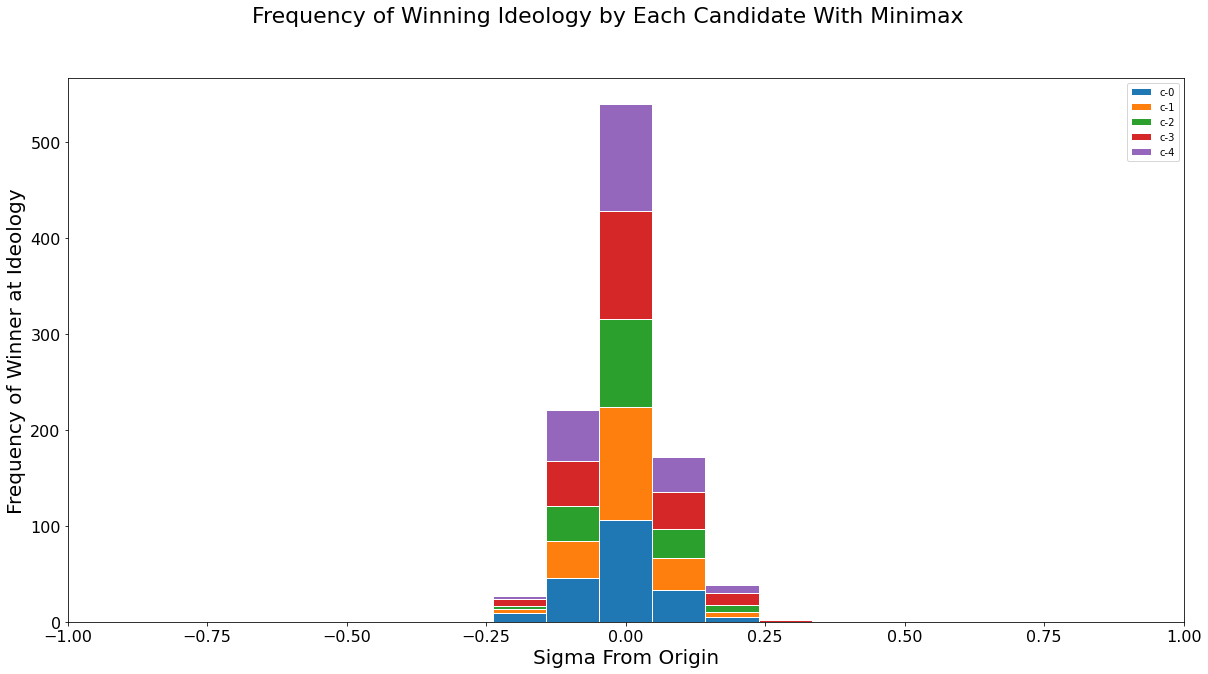

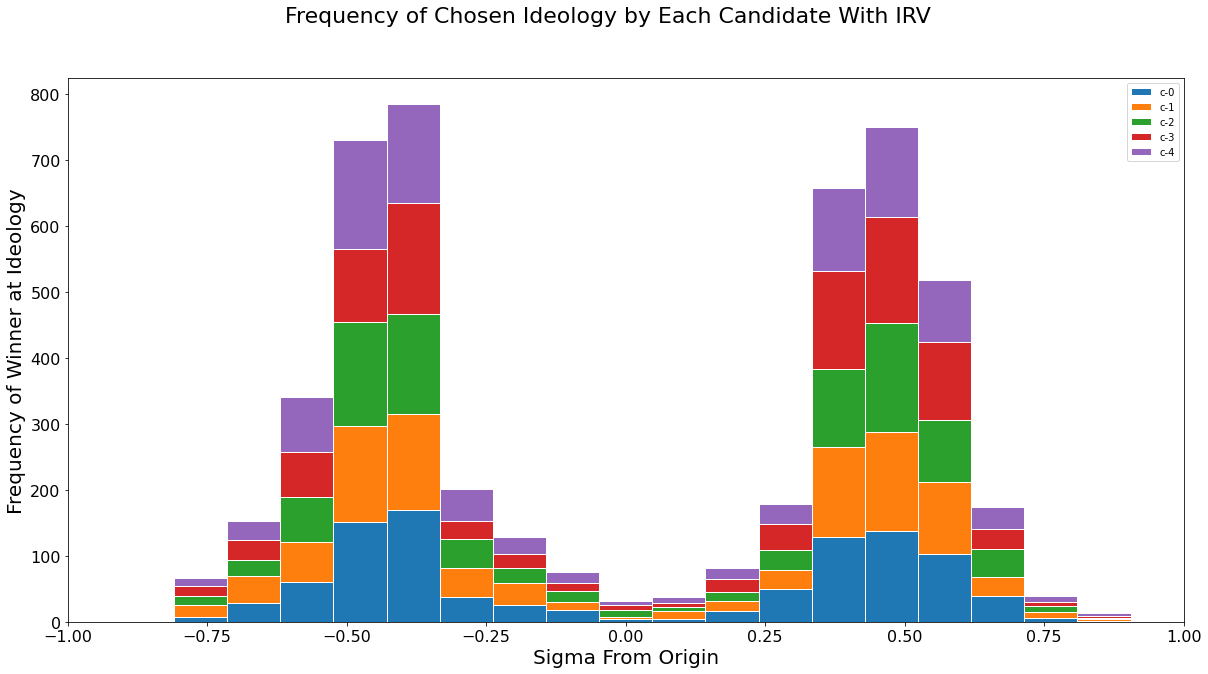

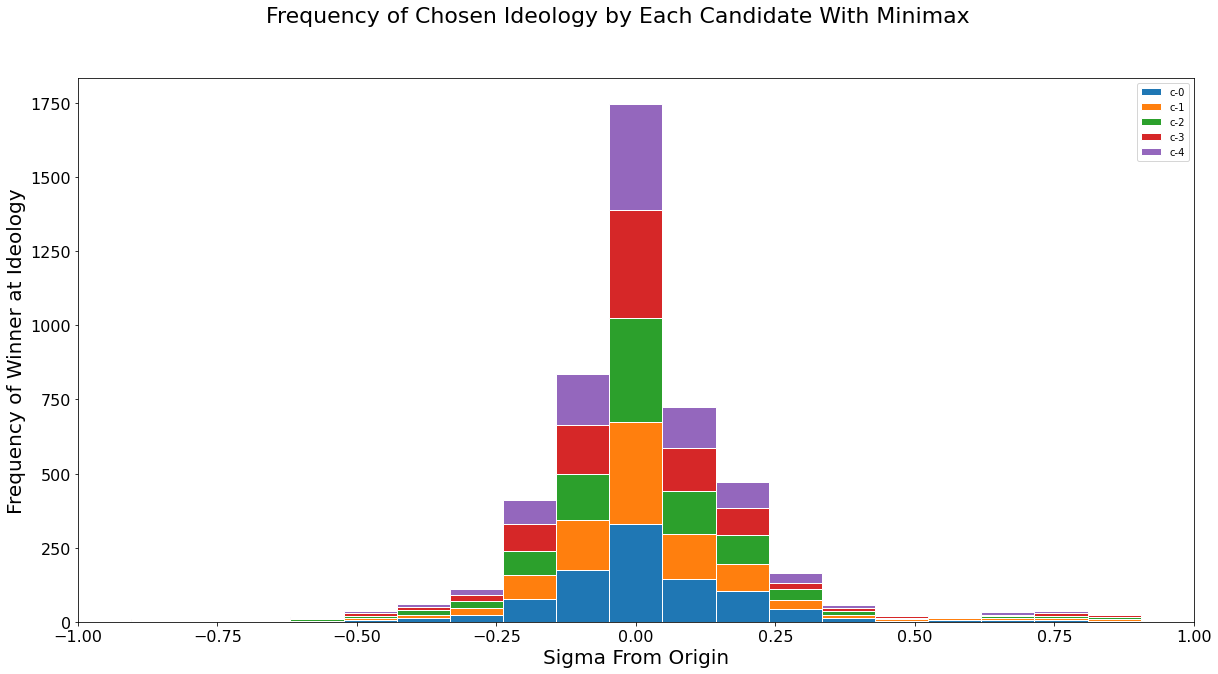

In [52]:
names = ["c-0", "c-1", "c-2", "c-3", "c-4"]
def make_plots():
    results = [results_for_candidate(irv_wc_s, n, True) for n in names]
    plot_results(results, f"Frequency of Winning Ideology by Each Candidate With IRV", names)
    plt.savefig("wins_by_candidate_irv.png")

    results = [results_for_candidate(h2h_wc_s, n, True) for n in names]
    plot_results(results, f"Frequency of Winning Ideology by Each Candidate With Minimax", names)
    plt.savefig("wins_by_candidate_h2h.png")

    results = [results_for_candidate(irv_wc_s, n, False) for n in names]
    plot_results(results, f"Frequency of Chosen Ideology by Each Candidate With IRV", names)
    plt.savefig("chosen_by_candidate_irv.png")

    results = [results_for_candidate(h2h_wc_s, n, False) for n in names]
    plot_results(results, f"Frequency of Chosen Ideology by Each Candidate With Minimax", names)
    plt.savefig("chosen_by_candidate_h2h.png")

make_plots()

In [53]:
def CumulativeNormalDistribution(xRaw: float) -> float:
    if xRaw < 0:
        neg = 1
    else:
        neg = 0

    k = 1.0 / (1.0 + 0.2316419 * abs(xRaw))
    y = ((((1.330274429 * k - 1.821255978) * k + 1.781477937) * k - 0.356563782) * k + 0.319381530) * k
    y = 1.0 - 0.398942280401 * np.exp(-0.5 * (xRaw * xRaw)) * y
    return (1.0 - neg) * y + neg * (1.0 - y)

In [54]:
def representation(sigma: float) -> float:
    pct = CumulativeNormalDistribution(sigma)
    return 100 * (1 - 2 * abs(.5 - pct))

In [55]:
def run_random_election(exp: Experiment) -> Tuple[Candidate, List[Candidate]]:
    candidates = exp.config.gen_candidates_2(5)
    # candidates = exp.config.gen_random_candidates(5)
    voters = exp.config.population.generate_unit_voters(exp.config.sampling_voters)
    ballots = [Ballot(v, candidates, unit_election_config) for v in voters]
    process = exp.config.election_constructor
    result = process.run(ballots, set(candidates))
    winner = result.winner()
    return winner, candidates

In [56]:
abs(-.1)

0.1

In [57]:
irv_wc_r = [run_random_election(irv_exp) for i in range(n_races)]
h2h_wc_r = [run_random_election(h2h_exp) for i in range(n_races)]

In [61]:
def mean(x: List[float]) -> float:
    return np.mean(np.array(x))

def describe_results(results: List[Tuple[Candidate, List[Candidate]]], label):
    winners = list(map(lambda x: x[0].ideology.vec[0], results))
    sigmas = [abs(x) for x in winners]
    percentages = [CumulativeNormalDistribution(x) for x in winners]
    rr = [representation(x) for x in winners]

    mean_sigma = mean(sigmas)
    mean_representation = mean(rr)

    print(f"%14s sigma from origin: %.3f representation %5.2f" % (label, mean_sigma, mean_representation))

In [62]:
describe_results(irv_wc_r, "IRV/Random")
describe_results(h2h_wc_r, "H2H/Random")

describe_results(irv_wc_s, "IRV/Strategic")
describe_results(h2h_wc_s, "H2H/Strategic")

    IRV/Random sigma from origin: 0.394 representation 69.76
    H2H/Random sigma from origin: 0.135 representation 89.31
 IRV/Strategic sigma from origin: 0.430 representation 66.93
 H2H/Strategic sigma from origin: 0.054 representation 95.66


In [ ]:
winners = list(map(lambda x: x[0].ideology.vec[0], results))
sigmas = [abs(x) for x in winners]
percentages = [CumulativeNormalDistribution(x) for x in winners]
rr = [representation(x) for x in percentages]

In [64]:
class Foo:
    count=0
    def __init__(self):
        Foo.count += 1
        pass


for i in range(10):
    x = Foo()

print(f"Foo.count {Foo.count}")
Foo.count=7

print(f"Foo.count {Foo.count}")

Foo.count 10
Foo.count 7
